In [1]:
# Cell 1: Imports and Data Loading
from tensorflow import keras
import cv2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix

# data load from keras
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


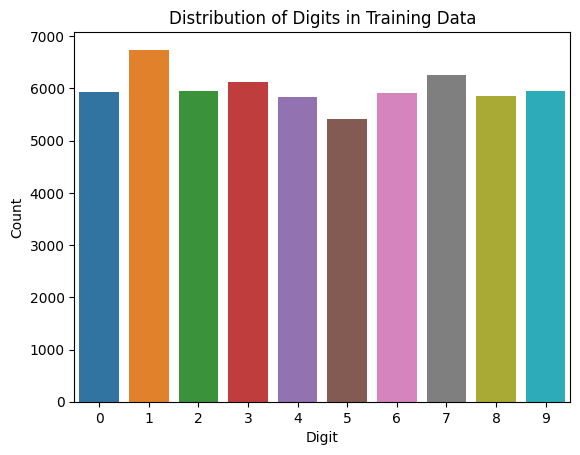

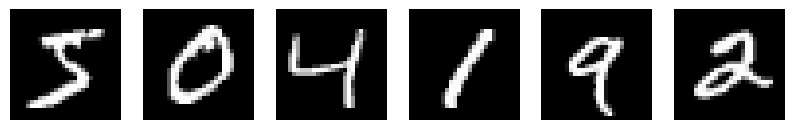

In [2]:
# Data Visualization

sns.countplot(x=y_train)
plt.title("Distribution of Digits in Training Data")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

# plot sample images
fig, axes = plt.subplots(1, 6, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.axis("off")
plt.show()


In [3]:
# Data Preprocessing
# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape for CNN input (add channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


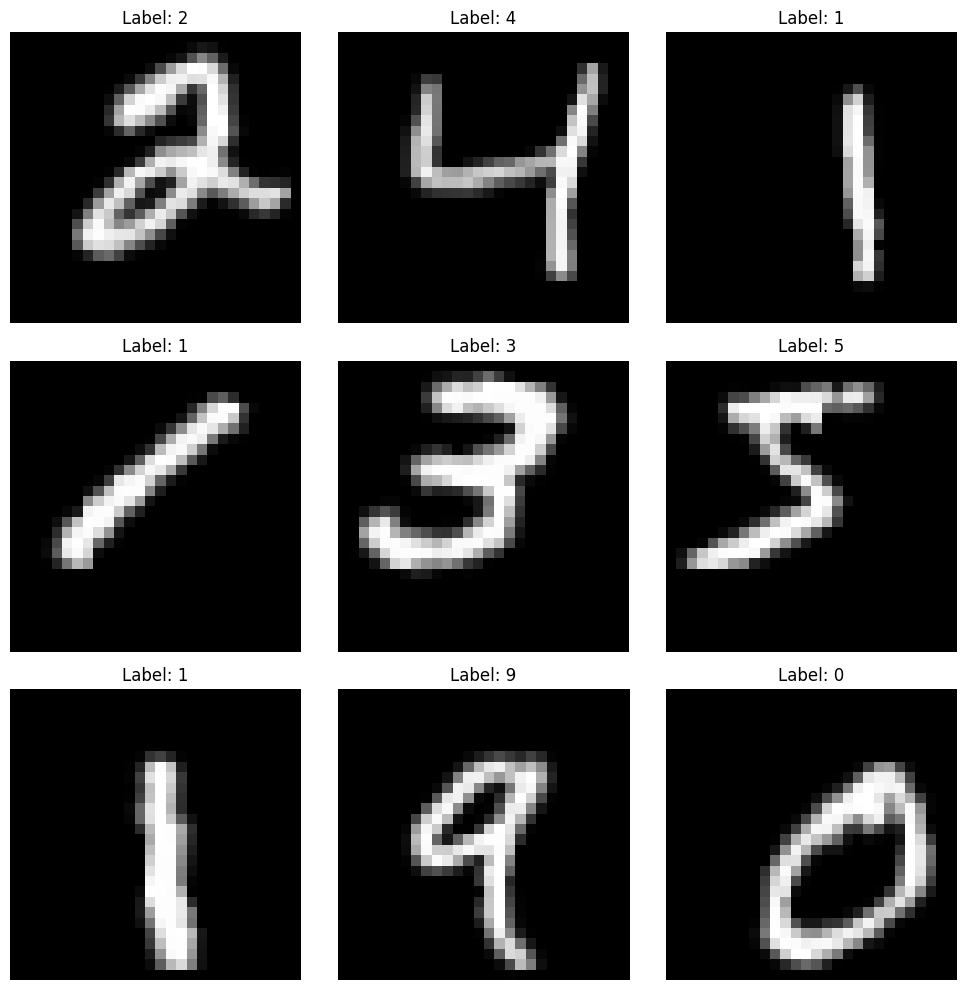

In [4]:
# Cell 4: Data Augmentation
# Create an image generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15, 
    shear_range=0.1,
    fill_mode='nearest'
)
datagen.fit(x_train)

# Plot some augmented examples
x_batch, y_batch = next(datagen.flow(x_train[:9], y_train[:9], batch_size=9))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i, (img, ax) in enumerate(zip(x_batch, axes)):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {np.argmax(y_batch[i])}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [5]:
# Cell 5: Improved Model Architecture
model = keras.Sequential([
    # First convolutional block
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Second convolutional block
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Classifier
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

In [6]:
# Compile , callbacks

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Stops training if the validation loss doesn’t improve for 10 epochs, preventing overfitting and saving time.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduces the learning rate by a factor of 0.2 if validation loss doesn’t improve for 5 epochs.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    'best_digit_moodel.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [7]:
#  Train 
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=30,  # More epochs with early stopping
    validation_data=(x_test, y_test),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/30
938/938 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8827
Epoch 1: val_accuracy improved from -inf to 0.97900, saving model to best_digit_moodel.h5
938/938 [==============================] - 59s 61ms/step - loss: 0.3785 - accuracy: 0.8827 - val_loss: 0.0633 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 2/30
937/938 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.9601
Epoch 2: val_accuracy improved from 0.97900 to 0.98930, saving model to best_digit_moodel.h5
938/938 [==============================] - 22s 24ms/step - loss: 0.1287 - accuracy: 0.9601 - val_loss: 0.0321 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 3/30
937/938 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9703
Epoch 3: val_accuracy did not improve from 0.98930
938/938 [==============================] - 20s 22ms/step - loss: 0.0982 - accuracy: 0.9703 - val_loss: 0.0378 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 4/30
937/938 [====================

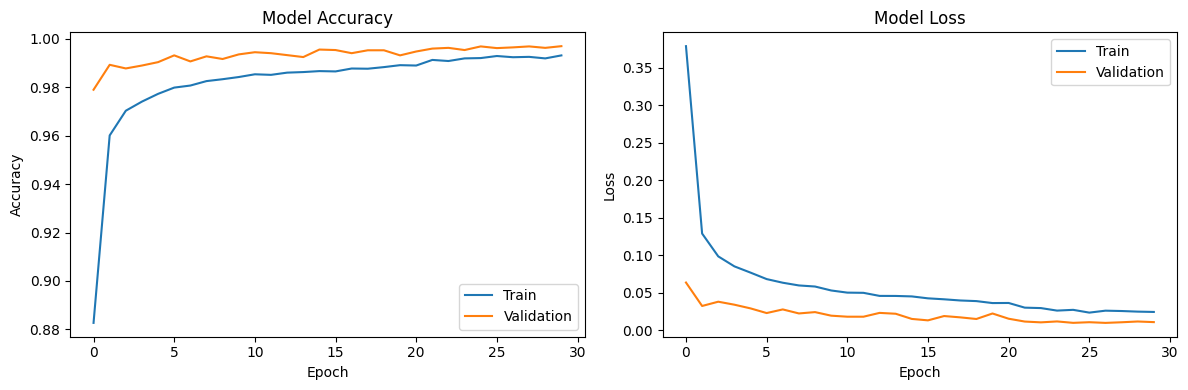

In [8]:
# Cell 8: Plot training history
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


In [9]:
# Cell 9: Load the best model and evaluate
from tensorflow.keras.models import load_model

# Load the best model saved during training
best_model = load_model('best_digit_moodel.h5')

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Test accuracy: 0.9970
Test loss: 0.0106


313/313 [==============================] - 1s 3ms/step


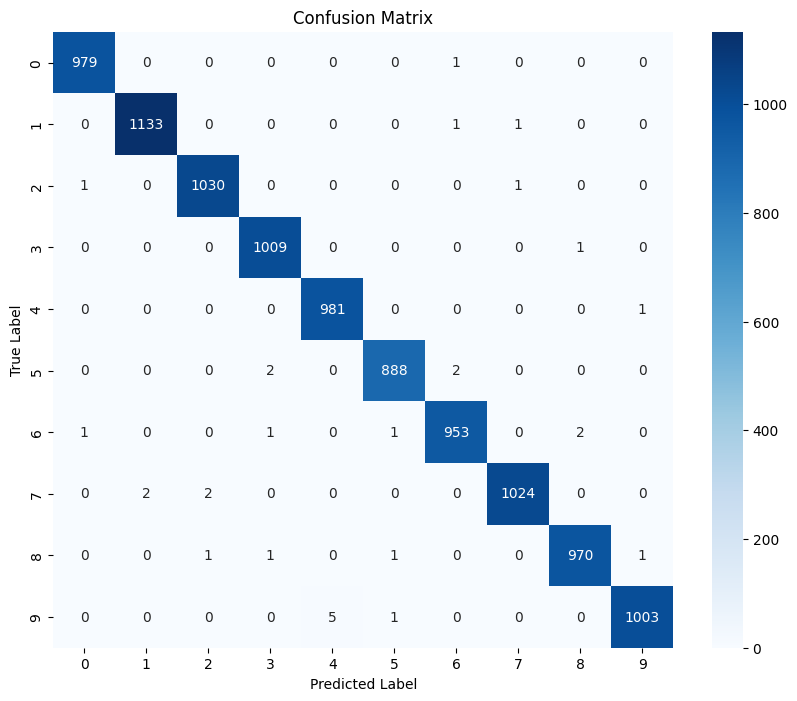

Most confused digit pairs:


In [10]:
#  Create a confusion matrix
# Get predictions and calculate confusion matrix
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Show which digits were most confused
print("Most confused digit pairs:")
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 5:  # Show pairs with more than 5 misclassifications
            print(f"True {i}, Predicted {j}: {cm[i, j]} instances")


1/1 [==============================] - 0s 27ms/step


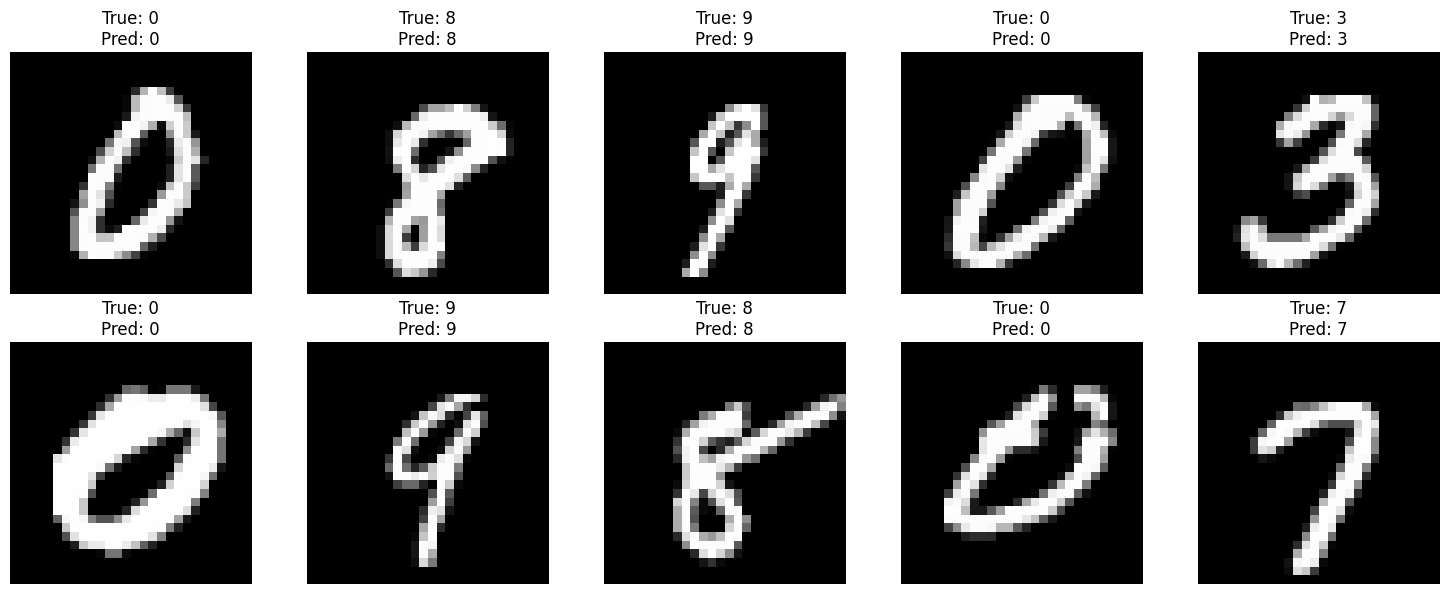

In [11]:
# Cell 11: Predict on random test images
# Visualize random predictions
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    index = np.random.randint(0, len(x_test))
    img = x_test[index].reshape(28, 28)
    true_label = np.argmax(y_test[index])
    predicted = np.argmax(best_model.predict(x_test[index].reshape(1, 28, 28, 1)))
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {predicted}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [13]:
# Cell 13: Save the model for later use
# Save the full model
best_model.save("digit_recognizer_improved110.h5")
print("Model saved successfully as 'digit_recognizer_improved11.h5'")


Model saved successfully as 'digit_recognizer_improved11.h5'
